# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [158]:
# Add any additional import statements you need here
import emoji
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/han/Desktop/USD/ADS 509/ADS509-Week1/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [22]:
lyrics_path = os.path.join(data_location, lyrics_folder)

artists = [x for x in os.listdir(lyrics_path) if 'ipynb' not in x]

lyrics = pd.DataFrame(columns=['artist', 'title', 'lyric'])

for artist in artists:
    
    path = os.path.join(data_location, lyrics_folder, artist)
    
    for file in os.listdir(path):
        
        if 'txt' not in file:
            continue
            
        song_path = os.path.join(path, file)
        
        with open(song_path, 'r') as file:
            song = file.readlines()
            
        title = song[0].replace('\n', '').strip()
        
        lyric = song[1:]
        lyric = ' '.join(lyric)
        lyric = lyric.replace('\n', '').strip()
        
        lyrics = pd.concat([lyrics, pd.DataFrame({
                                        'artist':artist,
                                        'title':title,
                                        'lyric':lyric
                                    }, index=[0])], ignore_index=True)
        
lyrics.head()

,artist,title,lyric
0,eminem,Rap God,"Look, I was gonna go easy on you not to hurt y..."
1,eminem,Hellbound (H&H Remix),"Welcome back to the stage of history (Yo, Sli..."
2,eminem,Infinite,"Aw, yeah (It's like this, like this) It's Emin..."
3,eminem,So Bad,"Yeah, haha, you feel that, baby? Yeah, I feel ..."
4,eminem,The King And I,"It goes: one for the trailer park, two for my ..."


In [31]:
lyrics.tail()

,artist,title,lyric
927,snoopdogg,Toyz N Da Hood,[Intro: Snoop Dogg - downsampled] What's happe...
928,snoopdogg,Cool,[Nate Dogg] Just yesterday I had to turn a bit...
929,snoopdogg,(O.J.) Wake Up,"[Intro:] [Snoop] Yeah man, this shit here go..."
930,snoopdogg,My Medicine,"(One, two...) [Intro: Snoop] Yeah, I like to ..."
931,snoopdogg,Murder Was The Case (DeathAfterVisualizingEter...,"[Intro: (Mista Grimm's ""Indo Smoke"" plays in t..."


In [ ]:
artists = [x for x in os.listdir(os.path.join(data_location, twitter_folder)) if 'ipynb' not in x]
artists = [x for x in artists if 'follower_data' in x]

twitter = pd.DataFrame()

for artist in artists:
    
    temp = pd.read_csv(os.path.join(twitter_folder, artist), sep='\t')
    temp['artist'] = artist.replace('_follower_data.txt', '').lower()
    
    twitter = pd.concat([twitter, temp], ignore_index=True)
    
twitter.head()

In [29]:
twitter_path = os.path.join(data_location, twitter_folder)

twitter = pd.DataFrame()

for artist in artists:
    
    file_path = [x for x in os.listdir(twitter_path) if artist in x.lower() and 'data' in x][0]
    temp = pd.read_csv(os.path.join(twitter_path, file_path), sep='\t')
    temp['artist'] = artist.replace('_follower_data.txt', '').lower()
    
    twitter = pd.concat([twitter, temp], ignore_index=True)
    
twitter.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,Tarik_k16,Tarık Keleş,1251272999497588736,Muhtemelen İstanbul,18,138,"Boun, Muhendis, temel bilimci, matematik asigi...",eminem
1,jisin_hatten,YZ//skrrrr,1453690241022193670,日本 東京,1,43,#邦楽 #洋楽 #HIPHOP #レゲエ #R&B #EDM #Rock #Eminem,eminem
2,zemy09631379,zemy,1336382129131778048,NaN,0,16,NaN,eminem
3,MaggieWee22,Maggie Wee,1362042628624187393,NaN,1,165,NaN,eminem
4,NameIsGuyBTW,HiMyNameIsGuy456,1519110907967770625,NaN,0,16,NaN,eminem


In [30]:
twitter.tail()

,screen_name,name,id,location,followers_count,friends_count,description,artist
119769,buduzere,Buduzere,1525987090772676608,NaN,0,57,Living my best life,snoopdogg
119770,njosh_jon,Jon Njosh,1520303800292192256,NaN,0,87,Fashionister,snoopdogg
119771,Mariah367561791,Mariah,1527578448197214209,NaN,1,4,NaN,snoopdogg
119772,puangorp,P.,1398535348636905475,NaN,3,235,NaN,snoopdogg
119773,sombre_symphony,Sombre_symphony,1527163605325578240,NaN,23,170,«I was looking for love and found myself»,snoopdogg


In [60]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

sentiments = pd.read_csv('tidytext_sentiments.txt', sep='\t')[['word', 'sentiment']]

positive = pd.read_csv('positive-words.txt', sep='\t', header=33)
positive.columns = ['Positive Word']

negative = pd.read_csv('negative-words.txt', sep='\t', header=33, encoding='latin')
negative.columns = ['Negative Word']

In [74]:
scores = {}

scores['positive'] = set(positive['Positive Word'].str.lower().tolist() + sentiments[sentiments['sentiment']=='positive']['word'].str.lower().tolist())
scores['negative'] = set(negative['Negative Word'].str.lower().tolist() + sentiments[sentiments['sentiment']=='negative']['word'].str.lower().tolist())

In [77]:
print('There are {} positive words and {} negative words'.format(len(scores['positive']), len(scores['negative'])))

There are 3778 positive words and 7761 negative words


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [78]:
def analyze_sentiment(txt):
    
    txt = txt.lower()
    score = 0
    
    for word in txt.strip().split(' '):
        
        word = word.strip()
        
        if word in scores['positive']:
            score += 1
        
        elif word in scores['negative']:
            score -= 1
            
    return score

In [82]:
lyrics['Sentiment Score'] = lyrics.apply(lambda x: analyze_sentiment(x['lyric']), axis=1)

In [85]:
lyrics.sort_values('Sentiment Score', inplace=True)

In [87]:
lyrics[lyrics['artist']=='eminem']

,artist,title,lyric,Sentiment Score
354,eminem,Shit On You,"I'll shit on you Da da, da da, da da I'll shit...",-114
112,eminem,Kill You,"When I was just a little baby boy, My momma us...",-90
148,eminem,Quitter,"Yo, I dedicate to this to you To all my fans, ...",-85
102,eminem,Dead Wrong (Remix),"Bad Boy, baby Yeah, yeah Junior M.A.F.I.A., ye...",-70
33,eminem,Till I Collapse (Remix),"Sometimes you just feel tired, feel weak When ...",-61
...,...,...,...,...
220,eminem,White America,"America, we love you How many people are proud...",30
361,eminem,The Real Slim Shady,May I have your attention please? May I have y...,31
310,eminem,The Re-Up,"Boom boom chuck, boom b-boom chuck Boom boom c...",33
323,eminem,Searchin',"[Angela Workman:] Ain't no one special, specia...",38


In [88]:
lyrics[lyrics['artist']=='snoopdogg']

,artist,title,lyric,Sentiment Score
469,snoopdogg,Back Up Off Me,[Mean Green] What's up y'all? It's the Mean-st...,-90
490,snoopdogg,Dick Walk,"[Snoop Dogg:] We so controvencial, this dick i...",-71
687,snoopdogg,Down 4 My Niggas,"[C-Murder] Fuck them niggas, ha ha. Fuck them...",-64
596,snoopdogg,DP Gangsta,[Eddie Talking] This is a service public anno...,-64
876,snoopdogg,Slow Down,"Slow down cause I can't take the heat, slow do...",-54
...,...,...,...,...
590,snoopdogg,Drop It Like It's Hot,"Snoop, Snoop [Snoop Dogg:] When the pimp's in...",53
398,snoopdogg,Rise To The Top,Woo I'm tryna pull up to he coast line and Ask...,53
886,snoopdogg,Pure Gold,Though we are tried like silver in the fire We...,56
472,snoopdogg,Praise Him,I said I woke up early this morning I'm nowher...,62


In [91]:
print('Eminem Average Semantics : {:.2f}'.format(lyrics[lyrics['artist']=='eminem']['Sentiment Score'].mean()))
print('SnoopDogg Average Semantics : {:.2f}'.format(lyrics[lyrics['artist']=='snoopdogg']['Sentiment Score'].mean()))

Eminem Average Semantics : -10.05
SnoopDogg Average Semantics : 1.28


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Based on the analysis, SnoppDogg has higher though the number is still quite close to 0 (only a bit above 1). Meanwhile, Eminem's avg sentiment is -10 which is farther away from 0 (neutral). 

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

In [95]:
# Eminem's highest

eminem_highest = lyrics[(lyrics['artist']=='eminem') & (lyrics['Sentiment Score']==lyrics[lyrics['artist']=='eminem']['Sentiment Score'].max())]
display(eminem_highest)

eminem_highest['lyric'].item()

,artist,title,lyric,Sentiment Score
263,eminem,Superman,"You high, baby? Yeah Ya Talk to me You want me...",71


'You high, baby? Yeah Ya Talk to me You want me to tell you something? Uh-huh I know what you wanna hear  \'Cause I know you want me baby I think I want you too "I think I love you baby" I think I love you too I\'m here to save you girl Come be in Shady\'s world I wanna grow together Let\'s let our love unfurl You know you want me baby You know I want you too They call me Superman I\'m here to rescue you I wanna save you girl Come be in Shady\'s world "Ooh boy you drive me crazy" Bitch you make me hurl  They call me Superman Leap tall hoes in a single bound I\'m single now Got no ring on this finger now I\'d never let another chick bring me down In a relationship Save it bitch, babysit You make me sick Superman ain\'t savin\' shit Girl you can jump on Shady\'s dick Straight from the hip, cut to the chase I tell a motherfuckin\' slut to her face Play no games, say no names Ever since I broke up with what\'s-her-face I\'m a different man, kiss my ass Kiss my lips, bitch why ask? Kiss my 

In [102]:
# Eminem's highest

eminem_lowest = lyrics[(lyrics['artist']=='eminem') & (lyrics['Sentiment Score']==lyrics[lyrics['artist']=='eminem']['Sentiment Score'].min())]
display(eminem_lowest)

eminem_lowest['lyric'].item()

,artist,title,lyric,Sentiment Score
354,eminem,Shit On You,"I'll shit on you Da da, da da, da da I'll shit...",-114


'I\'ll shit on you Da da, da da, da da I\'ll shit on you Da da, da da, da da  I\'ll shit on you Da da, da da, da da I\'ll shit on you Da da, da da, da da  I\'ll shit on you I will shit on you I\'ll shit on you Girl you know it\'s true I\'ll shit on you Bitch or man I\'ll shit on you I will shit on you  I remain fatter than gluttony Taping bombs to the back of record companies Blow them up if they ain\'t want me The National Guard, they scared to hunt me I love beef; I got you hoes ducking me A drug thief, bitch I\'ll take your marijuana These slugs with keep your ass away from my corner I drown niggas in hundred degree saunas You can act a fool if you wanna (bitch) It\'s this lyrical piranha Strapped with a grenade, in the pool with your mama Attack her by the legs then I pull her to the bottom Twist nothing up like a condom Slap it if you fuckers got a problem When I see them, you hoes ending up in a fuckin\' mausoleum Or hidden in the trunk of a black and gold BM Pull in the garage w

A: Highest is `Superman` with the score of 71 while the lowest is `Shit On You` with the score of -114

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

In [104]:
# Snoopdogg's highest

snoopdogg_highest = lyrics[(lyrics['artist']=='snoopdogg') & (lyrics['Sentiment Score']==lyrics[lyrics['artist']=='snoopdogg']['Sentiment Score'].max())]
display(snoopdogg_highest)

snoopdogg_highest['lyric'].item()

,artist,title,lyric,Sentiment Score
680,snoopdogg,Trash Bags,[Female Voice:] You gotta come to freak girls ...,65


'[Female Voice:] You gotta come to freak girls right now It\'s poppin\', like, niggas is throwing money left to right I say you bring that bag Music Major  [K Camp (Snoop Dogg):] Trash bag, full of cash, full of cash Count that Trash bag, full of cash, full of cash Count that Count that up, count that up, count that up Count that Trash bag, full of cash, full of cash Count that (Twenties), count that (Hundreds), count that (Dollars), count that (Money), count that (Paper) Trash bag, full of cash, full of cash Count that  [Snoop Dogg:] Passion, Angy, Keshia, Brandy Tangy, paradise, obsession and candy Lily, butterfly What are you, what am I? Bella, Lauren, Linda Rose On the stage, on the pole Oceanate, Pina Colada At the top, on the bottom Ace of diamonds, keep \'em shinin\' Crazy girls oh yeah we got \'em Daisy it\'s crazy, and so as the home gon\' red Don\'t fuck around when it come around to pickin\' up that bread It\'s yours  [K Camp (Snoop Dogg):] Trash bag, full of cash, full of c

In [105]:
# Snoopdogg's lowest

snoopdogg_lowest = lyrics[(lyrics['artist']=='snoopdogg') & (lyrics['Sentiment Score']==lyrics[lyrics['artist']=='snoopdogg']['Sentiment Score'].min())]
display(snoopdogg_lowest)

snoopdogg_lowest['lyric'].item()

,artist,title,lyric,Sentiment Score
469,snoopdogg,Back Up Off Me,[Mean Green] What's up y'all? It's the Mean-st...,-90


'[Mean Green] What\'s up y\'all? It\'s the Mean-ster Green-ster THIS should be played in residential neighborhoods clubs, cars, at high volume Get (?) wodies, at high volume  [Master P - over Mean Green] UNNNNNGHHH! Where all my No Limit Soldiers at? WHAT? WHAT? WHAT? WHAT? Where y\'all at? WHAT? WHAT? WHAT? WHAT? (Throw \'em up, throw \'em up, throw \'em up) WHAT? WHAT? WHAT? WHAT? (Get \'em up, get \'em up, get \'em up)  [Chorus 2X: Master P] I\'m a Down South nigga so FUCK Y\'ALL NIGGAZ I\'m a West coast nigga so FUCK Y\'ALL NIGGAZ I\'m a East coast nigga so FUCK Y\'ALL NIGGAZ I\'m a Midwest nigga so FUCK Y\'ALL NIGGAZ  [Master P] Rented gat in his ride, wodie throw \'em up high We some No Limit Soldiers \'til the day that we die And everybody in my click be rowdy (UNNNNGHHH) (?) boot up, or shut up, or get routed! I\'m from the streets and I hang with killers I make music by the ghetto for the thugs and killers Wodie respect my hood, screamin C-P-3 Nigga and Magic and Snoop, over t

A: Highest is `Trash Bags` with the score of 65 while the lowest is `Back Up Off Me` with the score of -90

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

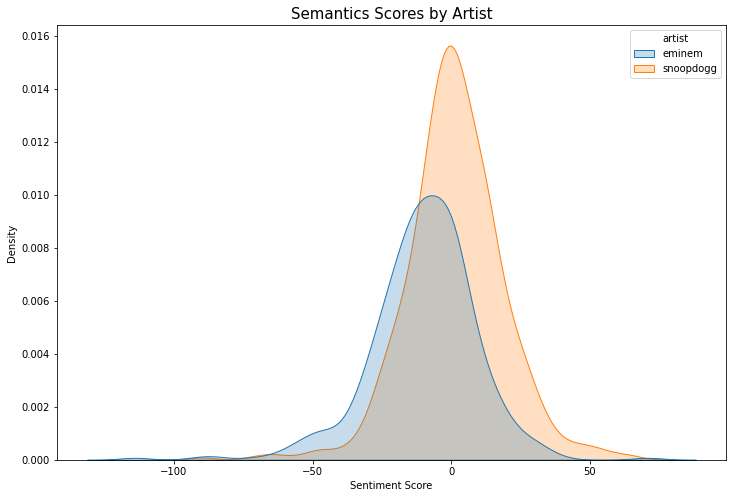

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.kdeplot(x='Sentiment Score', data=lyrics, hue='artist', fill=True)
ax.set_title("Semantics Scores by Artist", size=15)

plt.show();

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [179]:
twitter.fillna('', inplace=True)

In [180]:
positive_emojis = ['\U0001F602', '\U0001F4AF', '\U0001F60D', '\U0001F61D', '\U0001F60A',
                   '\U0001F618', '\U0001F601', '\U0001F607', '\U0001F604', '\U0001F609']

negative_emojis = ['\U0001F62D', '\U0001F614', '\U0001F629', '\U0001F612', '\U0001F622',
                   '\U0001F61E', '\U0001F615', '\U0001F62B', '\U0001F620', '\U0001F494']

In [181]:
def analyze_sentiment(txt):
    
    txt = txt.lower()
    score = 0
    
    for word in txt.strip().split(' '):
        
        word = word.strip()
        
        # Include emojis as well
        
        if word in scores['positive'] or word in positive_emojis:
            score += 1
        
        elif word in scores['negative'] or word in negative_emojis:
            score -= 1
            
    return score

Q: What is the average sentiment of your two artists? 

A:

In [182]:
twitter['Sentiment Score'] = twitter.apply(lambda x: analyze_sentiment(x['description']), axis=1)
twitter.groupby('artist').mean()[['Sentiment Score']]

,Sentiment Score
artist,
eminem,0.190891
snoopdogg,0.254376


---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

In [184]:
eminem_tweets = twitter[twitter['artist']=='eminem']
snoopdogg_tweets = twitter[twitter['artist']=='snoopdogg']

eminem_tweets.shape, snoopdogg_tweets.shape

((59898, 9), (59876, 9))

In [217]:
emojis_counts = pd.DataFrame()

# Eminem's
for p in positive_emojis:
    
    emojis_counts = pd.concat([emojis_counts, pd.DataFrame({
        'artist':'eminem',
        'emoji':p,
        'sentiment':'positive',
        'count':eminem_tweets['description'].str.count(p).sum()
    }, index=[0])], ignore_index=True)
    
for p in negative_emojis:
    
    emojis_counts = pd.concat([emojis_counts, pd.DataFrame({
        'artist':'eminem',
        'emoji':p,
        'sentiment':'negative',
        'count':eminem_tweets['description'].str.count(p).sum()
    }, index=[0])], ignore_index=True)
    
# Snoopdogg's
for p in positive_emojis:
    
    emojis_counts = pd.concat([emojis_counts, pd.DataFrame({
        'artist':'snoopdogg',
        'emoji':p,
        'sentiment':'positive',
        'count':snoopdogg_tweets['description'].str.count(p).sum()
    }, index=[0])], ignore_index=True)
    
for p in negative_emojis:
    
    emojis_counts = pd.concat([emojis_counts, pd.DataFrame({
        'artist':'snoopdogg',
        'emoji':p,
        'sentiment':'negative',
        'count':snoopdogg_tweets['description'].str.count(p).sum()
    }, index=[0])], ignore_index=True)

In [218]:
emojis_counts.sort_values('count', ascending=False).groupby(['artist', 'sentiment']).head(1)

,artist,emoji,sentiment,count
21,snoopdogg,💯,positive,466
1,eminem,💯,positive,405
39,snoopdogg,💔,negative,98
19,eminem,💔,negative,80


A: As it can be seen, they both have the same emojis for both positive and negative sentiments though the counts are slightly different.